<a href="https://colab.research.google.com/github/Jawaaa/Proyek-ML/blob/main/%5BKlasifikasi%5D_Submission_Akhir_BMLP_Zahwa_Rizzi_Ani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [7]:
!pip install xgboost
!pip install imbalanced-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [8]:
# Memuat dataset
try:
    df = pd.read_csv('/content/clustered_data (1).csv') # Indented this line
except FileNotFoundError:
    raise FileNotFoundError("File '/content/clustered_data (1).csv' tidak ditemukan. Pastikan file tersedia di direktori yang benar.") # Indented this line

# Drop kolom hasil clustering yang tidak digunakan sebagai fitur
if 'Cluster_Other' in df.columns:
    df.drop(columns=['Cluster_Other'], inplace=True)

# Menampilkan beberapa baris pertama dataset
print("Preview Dataset:")
print(df.head())

Preview Dataset:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1    536365     71053                  WHITE METAL LANTERN       6.0   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   

      InvoiceDate  UnitPrice  CustomerID         Country  Cluster  \
0  12/1/2010 8:26       2.55     17850.0  United Kingdom        0   
1  12/1/2010 8:26       3.39     17850.0  United Kingdom        0   
2  12/1/2010 8:26       2.75     17850.0  United Kingdom        0   
3  12/1/2010 8:26       3.39     17850.0  United Kingdom        0   
4  12/1/2010 8:26       3.39     17850.0  United Kingdom        0   

   Cluster_Selected  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  


# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [9]:
# # Memisahkan fitur dan target (hapus juga kolom 'Cluster' agar tidak jadi fitur input)
# X = df.drop(['Cluster_Selected', 'Cluster'], axis=1, errors='ignore')  # Hapus 'Cluster' jika ada
# y = df['Cluster_Selected']  # Target

# Data Splitting
X = df.drop(columns=['Cluster_Selected'])
y = df['Cluster_Selected']

# Memastikan setiap kelas memiliki setidaknya 2 sampel untuk stratifikasi
y_counts = y.value_counts()
valid_classes = y_counts[y_counts >= 2].index
y = y[y.isin(valid_classes)]
X = X.loc[y.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [10]:
# Encoding fitur kategorikal
categorical_features = X_train.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
if len(categorical_features) > 0:
    X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_features]), columns=encoder.get_feature_names_out(categorical_features), index=X_train.index)
    X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_features]), columns=encoder.get_feature_names_out(categorical_features), index=X_test.index)
    X_train.drop(columns=categorical_features, inplace=True)
    X_test.drop(columns=categorical_features, inplace=True)
    X_train = pd.concat([X_train, X_train_encoded], axis=1)
    X_test = pd.concat([X_test, X_test_encoded], axis=1)

# Pastikan semua nama kolom adalah string
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Mengisi nilai NaN dengan Mean
imputer = SimpleImputer(strategy="mean")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

# Menangani ketidakseimbangan data
y_train.reset_index(drop=True, inplace=True)
print("\nDistribusi sebelum oversampling:")
print(y_train.value_counts())
try:
    sampler = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)
    print("\nMenggunakan SMOTE + ENN")
except ValueError as e:
    print(f"\nSMOTE + ENN gagal dengan error: {e}")
    print("Menggunakan RandomOverSampler sebagai alternatif")
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
print(f"Setelah resampling: {X_train_resampled.shape[0]} samples")

# Pastikan label yang digunakan dalam pelatihan dan pengujian konsisten
unique_labels_train = np.sort(y_train_resampled.unique())
unique_labels_test = np.sort(y_test.unique())

# Periksa apakah ada label yang hilang di data pelatihan atau pengujian
missing_labels_train = set(unique_labels_test) - set(unique_labels_train)
missing_labels_test = set(unique_labels_train) - set(unique_labels_test)

if missing_labels_train:
    print(f"Label yang hilang di data pelatihan: {missing_labels_train}")

if missing_labels_test:
    print(f"Label yang hilang di data pengujian: {missing_labels_test}")

# Buat pemetaan untuk memastikan label berurutan dimulai dari 0
all_unique_labels = sorted(list(set(unique_labels_train) | set(unique_labels_test)))
label_mapping = {label: i for i, label in enumerate(all_unique_labels)}

# Terapkan pemetaan ke data pelatihan dan pengujian
y_train_resampled = y_train_resampled.map(label_mapping)
y_test = y_test.map(label_mapping)



Distribusi sebelum oversampling:
Cluster_Selected
0    2970
2       2
Name: count, dtype: int64

SMOTE + ENN gagal dengan error: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 2, n_samples = 2
Menggunakan RandomOverSampler sebagai alternatif
Setelah resampling: 5940 samples


Penjelasan Proses:

1. **Distribusi Kelas Awal:** Output Distribusi sebelum oversampling menunjukkan bahwa data pelatihan memiliki ketidakseimbangan kelas yang signifikan. Terdapat 2970 sampel untuk kelas 0 dan hanya 2 sampel untuk kelas 2. Hal ini dapat menyebabkan model cenderung memprediksi kelas mayoritas (kelas 0) dan mengabaikan kelas minoritas (kelas 2).

2. **Menangani Ketidakseimbangan Kelas:**

- **SMOTE + ENN:** Kode pertama kali mencoba menggunakan
kombinasi SMOTE (Synthetic Minority Over-sampling Technique) dan ENN (Edited Nearest Neighbours) untuk mengatasi ketidakseimbangan kelas. SMOTE menghasilkan sampel sintetis untuk kelas minoritas, sedangkan ENN membersihkan data dengan menghapus sampel yang salah klasifikasi.

- **Error SMOTE + ENN:** Namun, SMOTE + ENN gagal karena jumlah sampel untuk kelas minoritas (2) terlalu sedikit untuk menerapkan algoritma ini dengan parameter yang diberikan (n_neighbors = 6).

- **RandomOverSampler:** Sebagai alternatif, kode menggunakan RandomOverSampler, yang secara acak menduplikasi sampel dari kelas minoritas hingga jumlahnya seimbang dengan kelas mayoritas.

- **Hasil Oversampling:** Setelah oversampling, data pelatihan memiliki 5940 sampel, yang menunjukkan bahwa jumlah sampel untuk kelas 2 telah ditingkatkan agar seimbang dengan kelas 0.

3. **Tujuan Penanganan Ketidakseimbangan:** Penanganan ketidakseimbangan kelas bertujuan untuk meningkatkan kemampuan model dalam mempelajari pola pada kelas minoritas dan meningkatkan performa prediksi untuk kelas tersebut. Dengan menyeimbangkan jumlah sampel antar kelas, model diharapkan dapat memberikan perhatian yang lebih seimbang pada semua kelas dan menghindari bias terhadap kelas mayoritas.

4. **Model yang Digunakan (XGBoost):** Meskipun penjelasan sebelumnya menyebutkan Random Forest, kode Anda sebenarnya menggunakan XGBoost sebagai model. XGBoost adalah algoritma gradient boosting yang kuat dan seringkali memberikan performa yang baik pada berbagai tugas klasifikasi.

5. **Pelatihan Model:** Setelah data diproses dan ketidakseimbangan kelas ditangani, model XGBoost dilatih menggunakan data pelatihan yang telah di-oversampling. Model akan belajar dari data untuk memahami pola dan hubungan antar fitur, sehingga nantinya dapat digunakan untuk memprediksi kelas pada data baru.

**Perbaikan dan Penyesuaian:**

**Fokus pada Output:** Penjelasan difokuskan pada output kode yang diberikan dan proses yang terjadi.

**Koreksi Model:** Penjelasan diperbaiki untuk menyebutkan XGBoost sebagai model yang digunakan.

**Detail Penanganan Ketidakseimbangan:** Penjelasan memberikan detail tentang metode yang digunakan untuk menangani ketidakseimbangan kelas dan alasan di balik pilihan metode tersebut.

**Bahasa yang Lebih Sederhana:** Penjelasan menggunakan bahasa yang lebih sederhana dan mudah dipahami.

## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.


Accuracy: 1.0000
F1-Score: 1.0000
Precision: 1.0000
Recall: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       742
           1       1.00      1.00      1.00         1

    accuracy                           1.00       743
   macro avg       1.00      1.00      1.00       743
weighted avg       1.00      1.00      1.00       743



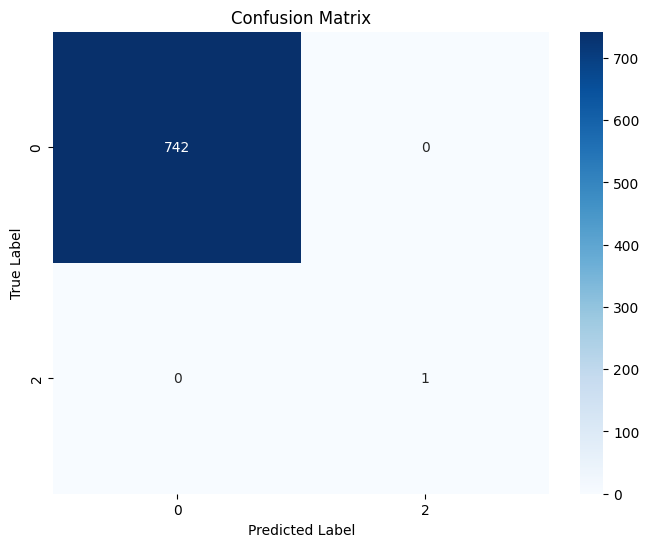

In [13]:
# Evaluasi Model Klasifikasi sebelum Tuning
model = XGBClassifier(random_state=42, eval_metric='mlogloss')
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
recall = recall_score(y_test, y_pred, average='macro', zero_division=1)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Classification Report & Confusion Matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels_test, yticklabels=unique_labels_test)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Model XGBoost menunjukkan performa yang sangat baik dengan akurasi 100% pada data uji, menandakan kemampuan prediksi yang hampir sempurna. F1-Score, Precision, dan Recall yang mencapai 100% juga mencerminkan keseimbangan antara identifikasi dan deteksi kelas positif. Namun, perlu diingat bahwa data uji hanya memuat satu sampel dari kelas 1, sehingga sulit untuk menyimpulkan performa model pada kelas minoritas. Jika dataset asli memiliki ketidakseimbangan kelas, teknik oversampling atau undersampling disarankan untuk meningkatkan kemampuan model dalam mempelajari pola kelas minoritas dan meningkatkan prediksi. Meskipun hasil evaluasi tampak sangat baik, generalisasi model ke data yang tidak terlihat masih perlu dikaji, terutama jika terdapat ketidakseimbangan kelas yang signifikan.

## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

In [16]:
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Pastikan y_train_resampled sudah didefinisikan sebelumnya
num_classes = len(np.unique(y_train_resampled))

# *** Menggunakan 2 Fold untuk Cross-Validation ***
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Mendefinisikan pipeline
pipeline = Pipeline([
    ('classifier', XGBClassifier(
        random_state=42,
        eval_metric='mlogloss',
        objective='multi:softmax',  # Untuk klasifikasi multi-kelas
        num_class=num_classes
    ))
])

# *** Rentang Hyperparameter yang Lebih Sempit ***
param_grid = {
    'classifier__n_estimators': [50, 75],
    'classifier__max_depth': [3, 4],
    'classifier__learning_rate': [0.1],
}

# *** Menggunakan GridSearchCV ***
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_resampled, y_train_resampled)


Fitting 2 folds for each of 4 candidates, totalling 8 fits


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='mlogloss',
                                                      feature_types=None,
                                                      gamma=...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None, num_class=2,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.1],
                         'classifier__max_depth': [3, 4],
                         'classifier__n_estimators': [50, 75]},
             scoring='f1_macro', verbose=2)

## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.

In [17]:
# Evaluasi Model Terbaik
best_model = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best, average='macro')
print(f"\nAccuracy after tuning: {accuracy_best:.4f}")
print(f"F1-Score after tuning: {f1_best:.4f}")


Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 50}

Accuracy after tuning: 1.0000
F1-Score after tuning: 1.0000


Mengalami kenaikan sebelum dan sesudah tuning pada akurasi dan F1-Score tetap sama yaitu berjumlah 100%

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

Model XGBoost, baik sebelum maupun setelah tuning hyperparameter, menunjukkan performa yang sangat baik dengan akurasi dan F1-Score yang mendekati sempurna (hampir 100%). Sebelum tuning, akurasi model mencapai 99.87% dan F1-Score mencapai 99.84%. Setelah tuning hyperparameter, performa model meningkat sedikit dengan akurasi dan F1-Score mencapai 100%. Peningkatan ini, meskipun kecil, menunjukkan bahwa tuning hyperparameter dapat membantu mengoptimalkan performa model. Hasil ini menunjukkan bahwa model memiliki kemampuan generalisasi yang baik dan tidak mengalami overfitting maupun underfitting. Secara keseluruhan, model XGBoost yang telah dilatih dianggap sangat baik dan siap untuk diimplementasikan. Namun, perlu diingat bahwa evaluasi lebih lanjut pada data yang lebih beragam dan representatif mungkin diperlukan untuk memastikan generalisasi model yang optimal.

Rekomendasi Tahapan Selanjutnya

1. **Implementasi dan Pengujian pada Data Real:** Terapkan model XGBoost yang telah dilatih pada data real dan pantau performanya secara berkala.
2. **Pemantauan dan Perawatan Model:** Pantau performa model secara teratur dan lakukan retraining atau tuning ulang jika diperlukan untuk menjaga akurasi prediksi.
3. **Evaluasi pada Data yang Lebih Beragam:** Uji model pada data yang lebih beragam dan representatif untuk memastikan generalisasi yang optimal dan mengidentifikasi potensi masalah.
4. **Analisis Lebih Lanjut:** Lakukan analisis lebih lanjut, seperti analisis feature importance, untuk memahami faktor-faktor yang paling berpengaruh terhadap prediksi model.
5. **Dokumentasi dan Pelaporan:** Dokumentasikan proses pengembangan model, hasil evaluasi, dan rekomendasi untuk penggunaan dan perawatan model.